In [1]:
!pip install --upgrade transformers
!pip install transformers bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 997.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00


In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSeq2SeqLM
from bertviz import model_view, head_view
import torch
from bertviz import model_view

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Babelscape/rebel-large"

#Load config and force eager attention
config = AutoConfig.from_pretrained(model_name)
config._attn_implementation = "eager"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config).to(device)
model.eval()

#Function to ensure the inputs are torch tensors
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    if isinstance(x, (list, tuple)):
        elems = [to_tensor(e) for e in x]
        return torch.stack(elems, dim=0)
    raise ValueError(f"Unsupported type: {type(x)}")

def get_generated_ids(gen_output):
    if isinstance(gen_output, torch.Tensor):
        return gen_output
    if hasattr(gen_output, "sequences"):
        return gen_output.sequences
    if isinstance(gen_output, (list, tuple)) and isinstance(gen_output[0], torch.Tensor):
        return gen_output[0]
    raise ValueError("Unable to extract sequences")

def normalize_token(t):
    return t.replace("Ġ", "").replace("▁", "").replace("##", "").strip()

def find_subtoken_positions(entity_text, src_tokens, tokenizer):
    if not entity_text:
        return []
    ent_ids = tokenizer(entity_text, add_special_tokens=False)["input_ids"]
    ent_tokens = tokenizer.convert_ids_to_tokens(ent_ids)
    norm_src = [normalize_token(t) for t in src_tokens]
    norm_ent = [normalize_token(t) for t in ent_tokens]

    #exact subsequence
    for i in range(len(src_tokens) - len(norm_ent) + 1):
        if norm_src[i:i+len(norm_ent)] == norm_ent:
            return list(range(i, i+len(norm_ent)))

    # fallback: greedy matching
    positions = []
    for nt in norm_ent:
        for i, s in enumerate(norm_src):
            if nt in s and i not in positions:
                positions.append(i)
                break
    return positions

#function for computing the attention focus on the entity
def compute_entity_focus(sentence, model, tokenizer, max_len=128, debug=False):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    gen_out = model.generate(
        **inputs,
        max_length=max_len,
        num_beams=4,
        early_stopping=True,
        return_dict_in_generate=True
    )
    gen_ids = get_generated_ids(gen_out).to(device)
    gen_text = tokenizer.batch_decode(gen_ids, skip_special_tokens=False)[0]

    #Forward pass with output_attentions=True
    with torch.no_grad():
        forward = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            decoder_input_ids=gen_ids,
            output_attentions=True,
            return_dict=True
        )

    #Cross-attention from last layer
    cross_attn_all = to_tensor(forward.cross_attentions)
    last_layer = cross_attn_all[-1]
    avg_heads = last_layer.mean(dim=1)
    attn_matrix = avg_heads[0].cpu().numpy()

    src_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(gen_ids[0].cpu().tolist())

    #Entity extraction from generated text
    triplets = []
    if "<triplet>" in gen_text:
        for p in gen_text.split("<triplet>")[1:]:
            p = p.replace("</s>", "").replace("<s>", "").strip()
            subj, rel, obj = "", "", ""
            if "<subj>" in p and "<obj>" in p:
                before_subj, after_subj = p.split("<subj>", 1)
                subj = before_subj.strip()
                if "<obj>" in after_subj:
                    obj, rel = after_subj.split("<obj>", 1)
                    obj, rel = obj.strip(), rel.strip()
            triplets.append({"subject": subj, "relation": rel, "object": obj})

    #locate entities in source tokens
    entity_positions = []
    for t in triplets:
        for ent in [t["subject"], t["object"]]:
            pos = find_subtoken_positions(ent, src_tokens, tokenizer)
            entity_positions.extend(pos)
    entity_positions = sorted(set(entity_positions))

    if len(entity_positions) == 0:
        efr = 0.0
        per_step = [0.0] * attn_matrix.shape[0]
    else:
        efr = float(attn_matrix[:, entity_positions].sum() / (attn_matrix.sum() + 1e-12))
        per_step = [
            float(attn_matrix[t, entity_positions].sum() / (attn_matrix[t].sum() + 1e-12))
            for t in range(attn_matrix.shape[0])
        ]

    return {
        "sentence": sentence,
        "gen_text": gen_text,
        "triplets": triplets,
        "src_tokens": src_tokens,
        "tgt_tokens": tgt_tokens,
        "entity_positions": entity_positions,
        "efr": efr,
        "per_step": per_step
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Processing: Steve Jobs founded Apple.
Generated: <s><triplet> Steve Jobs <subj> Apple <obj> employer <triplet> Apple <subj> Steve Jobs <obj> founded by</s>
Triplets: [{'subject': 'Steve Jobs', 'relation': 'employer', 'object': 'Apple'}, {'subject': 'Apple', 'relation': 'founded by', 'object': 'Steve Jobs'}]
Entity positions: [1, 2, 4]
EFR: 0.09366074204444885
RFR: 0.9063392579555511
--------------------------------------------------
Processing: Apple was founded by Steve Jobs.
Generated: <s><triplet> Steve Jobs <subj> Apple <obj> employer</s>
Triplets: [{'subject': 'Steve Jobs', 'relation': 'employer', 'object': 'Apple'}]
Entity positions: [1, 5, 6]
EFR: 0.10296518355607986
RFR: 0.8970348164439201
--------------------------------------------------


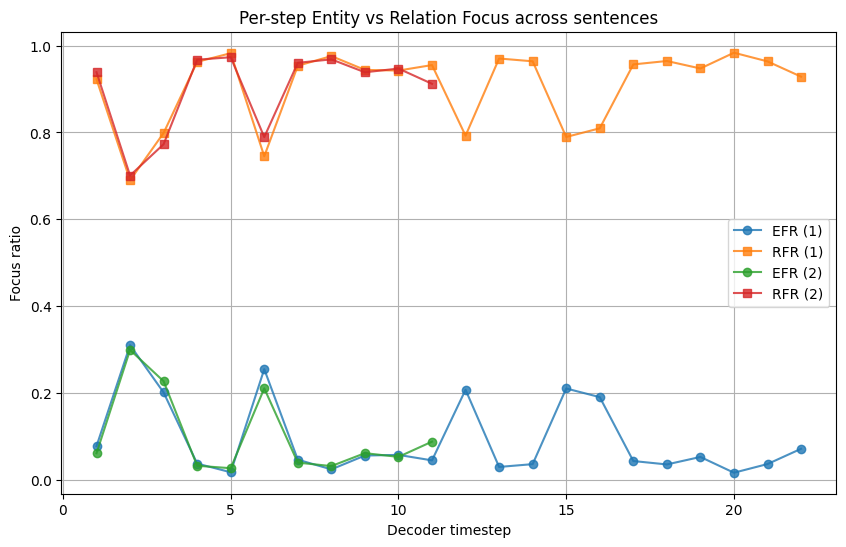

In [4]:
#Example sentences
sentences = [
    "Steve Jobs founded Apple.",
    "Apple was founded by Steve Jobs.",
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Thomas Edison invented the phonograph.
Generated: <s><triplet> phonograph <subj> Thomas Edison <obj> discoverer or inventor</s>
Triplets: [{'subject': 'phonograph', 'relation': 'discoverer or inventor', 'object': 'Thomas Edison'}]
Entity positions: [1, 2, 5, 6]
EFR: 0.09478086978197098
RFR: 0.905219130218029
--------------------------------------------------
Processing: The phonograph was invented by Thomas Edison.
Generated: <s><triplet> phonograph <subj> Thomas Edison <obj> discoverer or inventor</s>
Triplets: [{'subject': 'phonograph', 'relation': 'discoverer or inventor', 'object': 'Thomas Edison'}]
Entity positions: [2, 3, 7, 8]
EFR: 0.10330720245838165
RFR: 0.8966927975416183
--------------------------------------------------


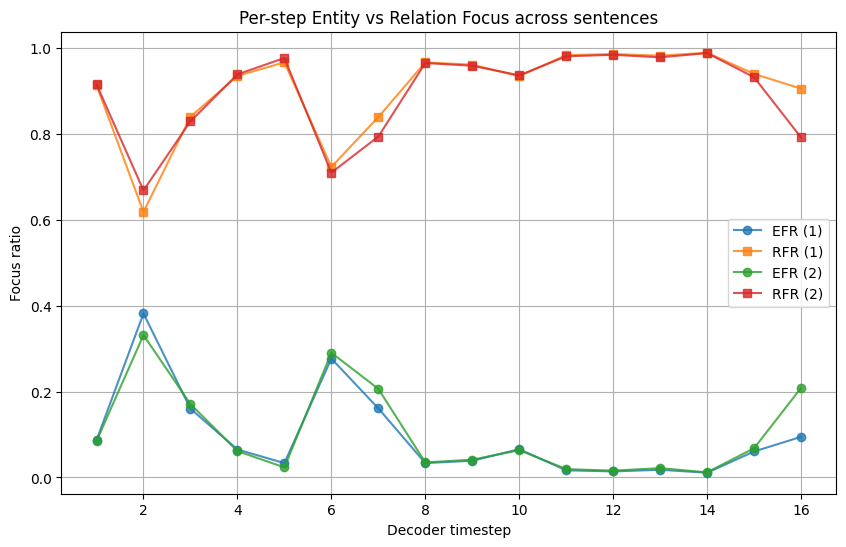

In [5]:
#Example sentences
sentences = [
    "Thomas Edison invented the phonograph.",
    "The phonograph was invented by Thomas Edison.",
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Alexander Fleming discovered penicillin.
Generated: <s><triplet> penicillin <subj> Alexander Fleming <obj> discoverer or inventor</s>
Triplets: [{'subject': 'penicillin', 'relation': 'discoverer or inventor', 'object': 'Alexander Fleming'}]
Entity positions: [1, 2, 4, 5, 6]
EFR: 0.1400323063135147
RFR: 0.8599676936864853
--------------------------------------------------
Processing: Penicillin was discovered by Alexander Fleming.
Generated: <s><triplet> Penicillin <subj> Alexander Fleming <obj> discoverer or inventor</s>
Triplets: [{'subject': 'Penicillin', 'relation': 'discoverer or inventor', 'object': 'Alexander Fleming'}]
Entity positions: [1, 2, 3, 7, 8]
EFR: 0.12667910754680634
RFR: 0.8733208924531937
--------------------------------------------------


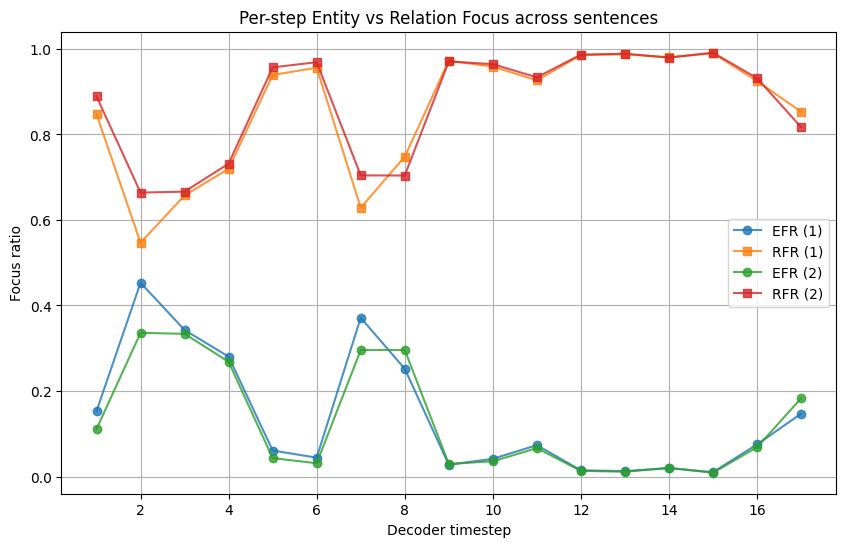

In [6]:
#Example sentences
sentences = [
    "Alexander Fleming discovered penicillin.",
    "Penicillin was discovered by Alexander Fleming.",
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: The Wright brothers built the first airplane.
Generated: <s><triplet> first airplane <subj> Wright brothers <obj> designed by</s>
Triplets: [{'subject': 'first airplane', 'relation': 'designed by', 'object': 'Wright brothers'}]
Entity positions: [2, 3, 6, 7]
EFR: 0.1157975047826767
RFR: 0.8842024952173233
--------------------------------------------------
Processing: The first airplane was built by the Wright brothers.
Generated: <s><triplet> Wright brothers <subj> airplane <obj> product or material produced</s>
Triplets: [{'subject': 'Wright brothers', 'relation': 'product or material produced', 'object': 'airplane'}]
Entity positions: [3, 8, 9]
EFR: 0.07780572026968002
RFR: 0.92219427973032
--------------------------------------------------


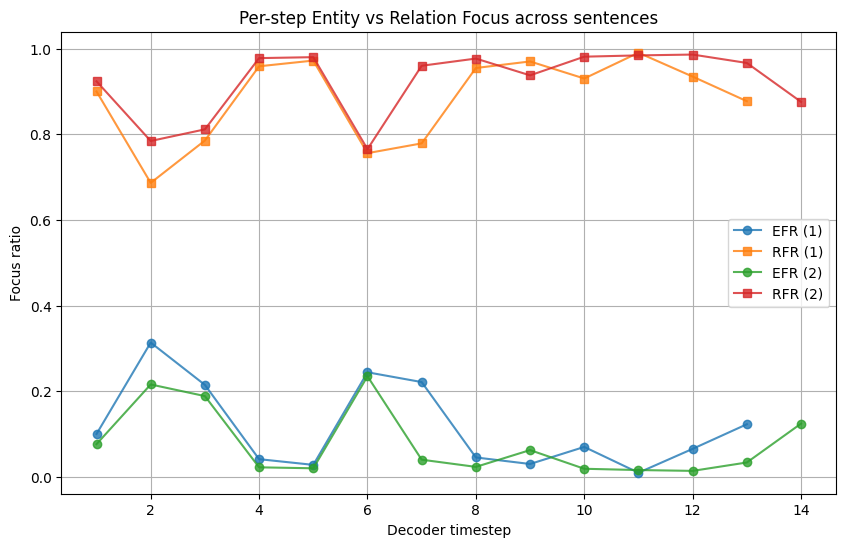

In [7]:
#Example sentences
sentences = [
    "The Wright brothers built the first airplane.",
    "The first airplane was built by the Wright brothers.",
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Wolfgang Amadeus Mozart composed The Magic Flute.
Generated: <s><triplet> The Magic Flute <subj> Wolfgang Amadeus Mozart <obj> composer</s>
Triplets: [{'subject': 'The Magic Flute', 'relation': 'composer', 'object': 'Wolfgang Amadeus Mozart'}]
Entity positions: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
EFR: 0.2440137267112732
RFR: 0.7559862732887268
--------------------------------------------------
Processing: The Magic Flute was composed by Wolfgang Amadeus Mozart.
Generated: <s><triplet> Magic Flute <subj> Wolfgang Amadeus Mozart <obj> composer <triplet> Wolfgang Amadeus Mozart <subj> Magic Flute <obj> notable work</s>
Triplets: [{'subject': 'Magic Flute', 'relation': 'composer', 'object': 'Wolfgang Amadeus Mozart'}, {'subject': 'Wolfgang Amadeus Mozart', 'relation': 'notable work', 'object': 'Magic Flute'}]
Entity positions: [2, 3, 4, 8, 9, 10, 11, 12, 13]
EFR: 0.19097547233104706
RFR: 0.8090245276689529
--------------------------------------------------


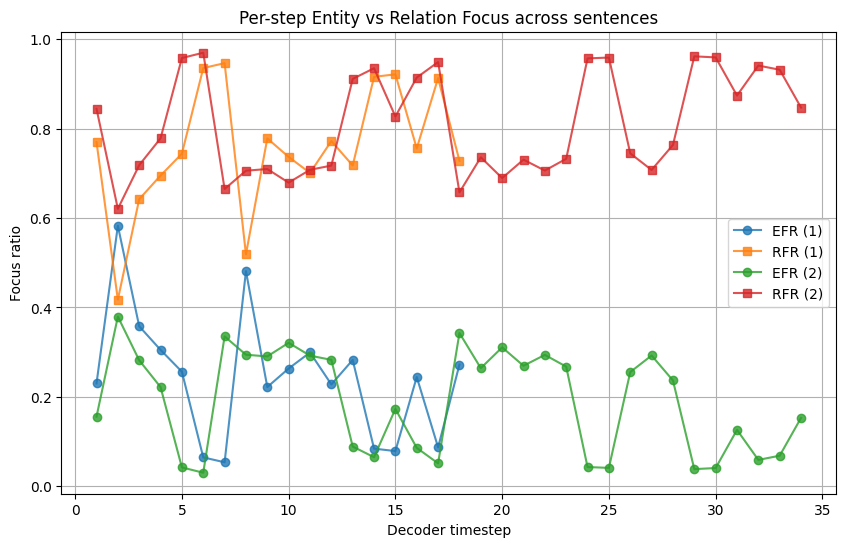

In [8]:
#Example sentences
sentences = [
    "Wolfgang Amadeus Mozart composed The Magic Flute.",
    "The Magic Flute was composed by Wolfgang Amadeus Mozart.",
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()

Processing: Galileo Galilei improved the telescope.
Generated: <s><triplet> telescope <subj> Galilei <obj> discoverer or inventor</s>
Triplets: [{'subject': 'telescope', 'relation': 'discoverer or inventor', 'object': 'Galilei'}]
Entity positions: [1, 2, 4, 8]
EFR: 0.08700568228960037
RFR: 0.9129943177103996
--------------------------------------------------
Processing: The telescope was improved by Galileo Galilei.
Generated: <s><triplet> Galileo Galilei <subj> telescope <obj> field of work</s>
Triplets: [{'subject': 'Galileo Galilei', 'relation': 'field of work', 'object': 'telescope'}]
Entity positions: [2, 4, 6, 7]
EFR: 0.13415955007076263
RFR: 0.8658404499292374
--------------------------------------------------


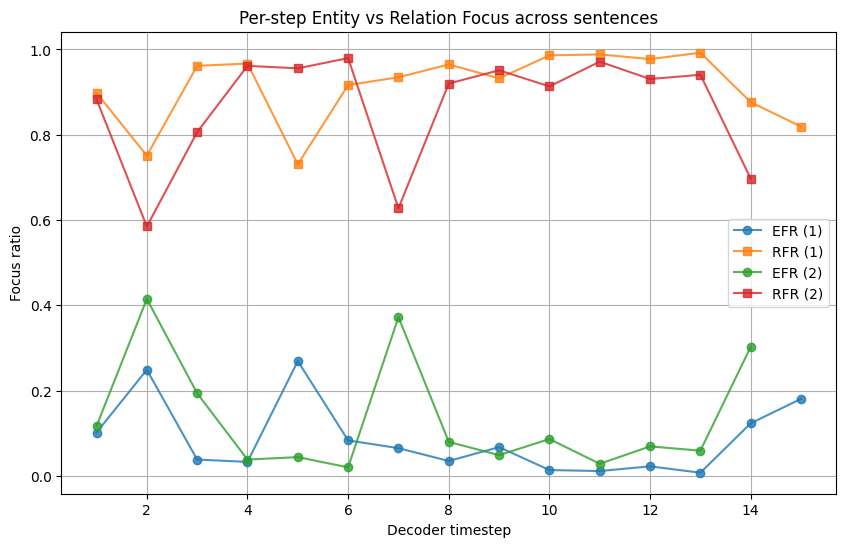

In [9]:
#Example sentences
sentences = [
    "Galileo Galilei improved the telescope.",
    "The telescope was improved by Galileo Galilei.",
]

results = []

for s in sentences:
    print("Processing:", s)
    res = compute_entity_focus(s, model, tokenizer, debug=True)
    print("Generated:", res["gen_text"])
    print("Triplets:", res["triplets"])
    print("Entity positions:", res["entity_positions"])
    print("EFR:", res["efr"])
    print("RFR:", 1 - res["efr"])
    print("-" * 50)
    results.append((s, res))

#Plot of EFR and RFR for each sentence
plt.figure(figsize=(10, 6))

for idx, (s, res) in enumerate(results):
    x = list(range(1, len(res["per_step"]) + 1))

    #EFR curve
    plt.plot(x, res["per_step"], marker='o',
             label=f"EFR ({idx+1})", alpha=0.8)

    #RFR curve
    rfr_curve = [1 - v for v in res["per_step"]]
    plt.plot(x, rfr_curve, marker='s',
             label=f"RFR ({idx+1})", alpha=0.8,)

plt.xlabel("Decoder timestep")
plt.ylabel("Focus ratio")
plt.title("Per-step Entity vs Relation Focus across sentences")
plt.legend()
plt.grid(True)
plt.show()